In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [12]:
df = pd.read_excel('../data/Online Retail.xlsx')

### Retention Rate

Cohort analysis is used to visualize user retention rate. Users are grouped based on their first purchase month. Then, a retention rate is calculated each month.

In [23]:
# Filter out Customer records without ID
df = df[~df.CustomerID.isnull()].copy()

# Find the first purchase date for each customer
df['InitialPurchaseDate'] = df.groupby('CustomerID')['InvoiceDate'].transform('min')

# Use the first purchase date as the basis of each cohort 
df['CohortMonth'] = df['InitialPurchaseDate'].apply(lambda x: datetime.datetime(int(x.year), int(x.month),1))

# Find the number of month has lapsed since first purchase for each row
def get_month_diff(x):
    return (x.InvoiceDate.year - x.CohortMonth.year) * 12 + (x.InvoiceDate.month - x.CohortMonth.month)

df['CohortIndex'] = df.apply(get_month_diff, axis=1)

In [76]:
# Prepare the df for pivot table
df_cohort = df.groupby(['CohortMonth','CohortIndex'])['CustomerID'].nunique().reset_index()


cohort_pivot = df_cohort.pivot(index='CohortMonth',
                        columns = 'CohortIndex',
                        values = 'CustomerID'
                       )

# Use the first column of the cohort table as the basis for calculating retention
cohort_basis = cohort_pivot.iloc[:,0]

# Divide every column by the first column to find the retention %
cohort_pivot = cohort_pivot.divide(cohort_basis, axis=0).round(2) 

# Convert CohortMonth from timestamp to string, so that when seaborn displays the heatmap, 
# the first column is '2010-12-01' instead of '2010-12-01T00:00:00.000000'
cohort_pivot.index = cohort_pivot.index.map(lambda x: x.strftime('%Y-%m-%d'))

In [77]:
cohort_pivot.head()

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
2010-12-01,1.0,0.38,0.33,0.39,0.36,0.40,0.38,0.35,0.35,0.39,0.37,0.50,0.27
2011-01-01,1.0,0.24,0.28,0.24,0.33,0.30,0.26,0.26,0.31,0.35,0.37,0.15,NaN
2011-02-01,1.0,0.25,0.19,0.28,0.27,0.25,0.26,0.28,0.26,0.31,0.09,NaN,NaN
2011-03-01,1.0,0.19,0.25,0.22,0.23,0.18,0.26,0.24,0.29,0.09,NaN,NaN,NaN
2011-04-01,1.0,0.23,0.22,0.21,0.21,0.24,0.23,0.26,0.08,NaN,NaN,NaN,NaN


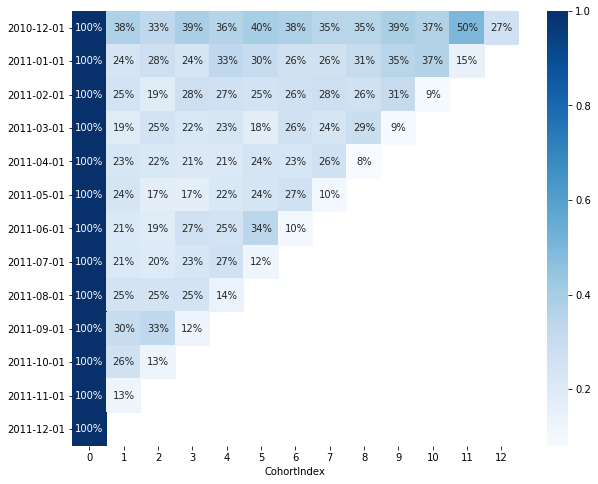

In [78]:
plt.figure(figsize=(10,8))
sns.heatmap(data = cohort_pivot,
            annot = True,
            fmt = '.0%',
            cmap = 'Blues'
           )

In [ ]:
### Observation 

The '2010-12-01' cohort has higher retention rate than the rest of the cohorts. 

#### Retention after first month of purchase

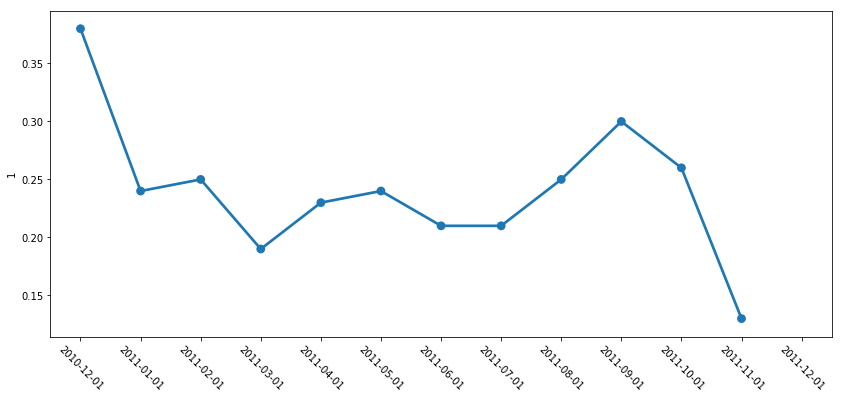

In [86]:
plt.figure(figsize=(14,6))
plt.xticks(rotation=-45)
sns.pointplot(x=cohort_pivot.index, y=cohort_pivot.iloc[:,1])

/Users/cheng/.envs/edge/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


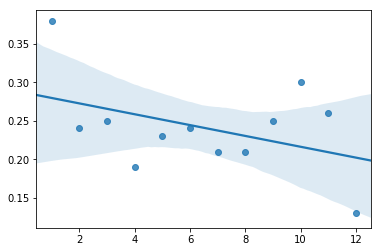

In [111]:
sns.regplot(x=list(range(1,len(cohort_pivot.index))), 
            y=list(cohort_pivot.iloc[:,1].values)[:-1]) # the last value is null, thus [:-1] is used to exclude it

The overall retention rate after first month is going downwards.